In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
#Use uppercase to identify or make it a class or object of their own.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)
# Collect the names of tables within the database
inspector_gadget.get_table_names()

['measurement', 'station']

In [10]:
# Using the inspector_gadget to print the column names within the 'messurements' table and its types
#For SQLAlchemy, inspect is my favorite thing!  Too much fun!
columns = inspector_gadget.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using the inspector_gadget to print the column names within the 'messurements' table and its types
#For SQLAlchemy, inspect is my favorite thing!  Too much fun!
columns = inspector_gadget.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set using engine execute and traditional SQL syntax and fetchall
#,execute means run this command or line of code -- indicative of tradtional sql being used
engine.execute('SELECT max(date) FROM Measurement').fetchall()


[('2017-08-23',)]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
#By using inspector_gadget above, I know the structure of the tables to complete the query below:
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation_data).set_index('date')
# Rename the column to make it clearer and easier to work with later
precipitation_df=precipitation_df.rename(columns={'prcp':'precipitation'})

precipitation_df=precipitation_df.sort_values(by='date').dropna()
precipitation_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


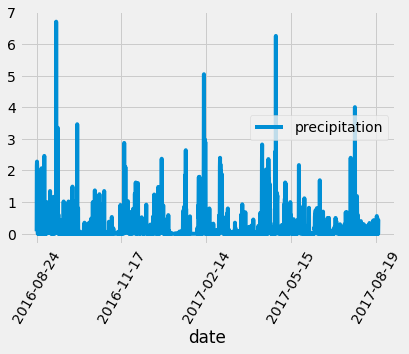

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=60)
plt.savefig("Images/Precipitation_analysis.png")
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_total = session.query(Station.id).count() 
print(f'There are {station_total} stations available in this dateset.')

There are 9 stations available in this dateset.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#station member identified from instpector_gadget above.
#Using the count that is made available from the func count that was imported in with SQLAlchemy in line one
#Since SQL lite and the use of classes - we can use session.query instead traditional SQL syntax

#\ just allows the coding to go to the next line
#I think I need to count the number of time stations appear in the dataset, then groupby the stations
#Then order by the count of stations.
#Using the desc() and .all to get a list of all of the stations or at least the head and tail?
#ASK TUTOR###What does the .desc() . all do?  Found in an exercise or via googing.  It works, but don't fully undersand

stations_active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Based on the above, the most active station appears to be 'USC00519281' withj 2772
#Will use the min, max and avg function used in the import for SQL Alchemy in line #1
#Will create station most active member to make the query dynamic -- all I will need to do is change what it equals to run the
#the same query

#First [0] gets the first tuple from the list and the second [0] gets the first value of the tuple
station_most_active=stations_active[0][0]
station_most_active

#tobs is member identified in the instpector_gadget process above.
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == station_most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Using the most active station id

#Determined on Output from line 20 that USC00519281 is the most active station ID 
tobs_results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-24").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == station_most_active).all()

#Convert to pandas dataframe
tobs_results_df = pd.DataFrame(tobs_results)
tobs_results_df


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


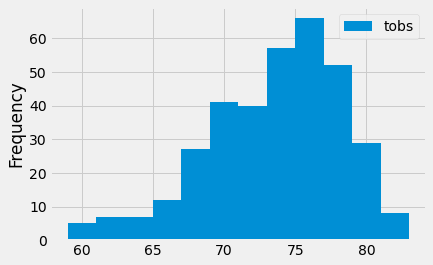

In [21]:
#Create a histrogram using the tobs_results_df
tobs_results_df.plot.hist(bins=12)


In [30]:
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

     # Convert the list to Dictionary
    all_prcp = {}
    for date,prcp  in precipitation_data:
        all_prcp["date"] = date
        all_prcp["prcp"] = prcp
    all_prcp

# Close session

In [22]:
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

     # Convert the list to Dictionary
    all_prcp = {}
    for date,prcp  in precipitation_data:
        all_prcp["date"] = date
        all_prcp["prcp"] = prcp
     
    display.all_prcp()
    
    #session.close()
               
    #return jsonify(all_prcp)

In [23]:
# Close Session
session.close()

In [ ]:
########################
#Import Dependencies
########################
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#Import Flask and jsonify
#Flask will be used to create the server and jsonify will convert query results to json
from flask import Flask, jsonify

##############################################
#Create Engine, automap, save table references
##############################################

# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

########################################
#Setup Flask
########################################
app = Flask(__name__)

#################################################
# Flask Routes
#################################################
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Welcome to the SQL-Alchemy APP API - SURFS UP!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/[start_date format:yyyy-mm-dd]<br/>"
        f"/api/v1.0/[start_date format:yyyy-mm-dd]/[end_date format:yyyy-mm-dd]<br/>"
    )


@app.route("/api/v1.0/precipitation")
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

     # Convert the list to Dictionary
    all_prcp = {}
    for date,prcp  in precipitation_data:
        all_prcp["date"] = date
        all_prcp["prcp"] = prcp
        
    session.close()
               
    return jsonify(all_prcp)

    
@app.route("/api/v1.0/stations")
def stations():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    stations_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

    # Create a list of stations ids
    stations_ids = []
    for station_active in stations_active:
        station = station_active[0]
        stations_ids.append(station)
    
    # Return a JSON list from the dataset
    stations = {}
    stations['stations'] = stations_ids
    
    session.close()
    
    return jsonify(stations)

    
@app.route("/api/v1.0/tobs")
def tobs():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    
    # Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
    stations_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    
    # Find most active station
    station_most_active=stations_active[0][0]
    
    # Dine Weather for Most Active Station
    weather = session.query(func.min(Measurement.tobs),\
    func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).filter(Measurement.station == station_most_active).all()

    # Convert tuple to a list
    weather_list = list(weather[0])
     
    # Return a JSON list from the dataset
    station_weather = {}
    station_weather['weather'] = weather_list
    
    session.close()
    
    return jsonify(station_weather)
     
    
@app.route("/api/v1.0/<start>")
def startdate(start):
    # Create our session (link) from Python to the DB
    session = Session(engine)
    # start_date = '2015-07-19'
    # Query all tobs
    query_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start).all()

    session.close()

    # Create a dictionary and append to a list of start_date_tobs_list
    start_date_tobs_list = []
    for min_tob, avg_tob, max_tob in query_results:
        # Create empty dictionary
        start_date_tobs_dictionary = {}
        # Assign dictionary values with keys
        start_date_tobs_dictionary["min_temp"] = min_tob
        start_date_tobs_dictionary["avg_temp"] = avg_tob
        start_date_tobs_dictionary["max_temp"] = max_tob
        # Append list with dictionary
        start_date_tobs_list.append(start_date_tobs_dictionary)
    
    session.close()
    
    return jsonify(start_date_tobs_list)


@app.route('/api/v1.0/<start>/<end>')
def date_range(start, end):
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of min, avg and max tobs for start and end dates"""
    # Query all tobs

    query_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start).filter(Measurement.date <= end).all()
  
    # Create a dictionary and append to a list named date_range_tobs_list
    date_range_tobs_list = []
    for min_tob, avg_tob, max_tob in query_results:
        date_range_tobs_dictionary = {}
        date_range_tobs_dictionary["min_temp"] = min_tob
        date_range_tobs_dictionary["avg_temp"] = avg_tob
        date_range_tobs_dictionary["max_temp"] = max_tob
        date_range_tobs_list.append(date_range_tobs_dictionary)
    
    session.close()

    return jsonify(date_range_tobs_list)


if __name__ == '__main__':
    app.run()

In [ ]:
########################
#Import Dependencies
########################
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#Import Flask and jsonify
#Flask will be used to create the server and jsonify will convert query results to json
from flask import Flask, jsonify

##############################################
#Create Engine, automap, save table references
##############################################

# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

########################################
#Setup Flask
########################################
app = Flask(__name__)

#################################################
# Flask Routes
#################################################
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Welcome to the SQL-Alchemy APP API - SURFS UP!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/[start_date format:yyyy-mm-dd]<br/>"
        f"/api/v1.0/[start_date format:yyyy-mm-dd]/[end_date format:yyyy-mm-dd]<br/>"
    )


@app.route("/api/v1.0/precipitation")
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

     # Convert the list to Dictionary
    all_prcp = {}
    for date,prcp  in precipitation_data:
        all_prcp["date"] = date
        all_prcp["prcp"] = prcp
        
    session.close()
               
    return jsonify(all_prcp)

    
@app.route("/api/v1.0/stations")
def stations():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    stations_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

    # Create a list of stations ids
    stations_ids = []
    for station_active in stations_active:
        station = station_active[0]
        stations_ids.append(station)
    
    # Return a JSON list from the dataset
    stations = {}
    stations['stations'] = stations_ids
    
    session.close()
    
    return jsonify(stations)

    
@app.route("/api/v1.0/tobs")
def tobs():
    # Create our session (link) from Python to the DB
    session = Session(engine)
    
    # Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
    stations_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    
    # Find most active station
    station_most_active=stations_active[0][0]
    
    # Dine Weather for Most Active Station
    weather = session.query(func.min(Measurement.tobs),\
    func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).filter(Measurement.station == station_most_active).all()

    # Convert tuple to a list
    weather_list = list(weather[0])
     
    # Return a JSON list from the dataset
    station_weather = {}
    station_weather['weather'] = weather_list
    
    session.close()
    
    return jsonify(station_weather)
    #return (station_weather)
     
    
@app.route("/api/v1.0/<start>")
@app.route('/api/v1.0/<start>/<end>')
def date_range(start, end=None):
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of min, avg and max tobs for start and end dates"""
    # Query all tobs
    if end==None:
        query_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start).all()
    else:
        query_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start).filter(Measurement.date <= end).all()
  
    # Create a dictionary and append to a list named date_range_tobs_list
    date_range_tobs_list = []
    for min_tob, avg_tob, max_tob in query_results:
        date_range_tobs_dictionary = {}
        date_range_tobs_dictionary["min_temp"] = min_tob
        date_range_tobs_dictionary["avg_temp"] = avg_tob
        date_range_tobs_dictionary["max_temp"] = max_tob
        date_range_tobs_list.append(date_range_tobs_dictionary)
    
    session.close()

    return jsonify(date_range_tobs_list)


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Feb/2022 20:21:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2022 20:21:27] "GET /api/v1.0/tobs HTTP/1.1" 200 -
